# Import Libraries

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from IPython.display import clear_output
from copy import deepcopy
from collections import OrderedDict
from matplotlib.patches import Rectangle
import os
from skimage.io import imread
import natsort as ns
import multiprocessing
from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D

%load_ext autoreload
%autoreload

In [2]:
# custom libraries
from helpers.helpers import *
from helpers.data_augment import *
from keras_helpers.unet import *
from keras_helpers.helpers import *
from keras_helpers.callbacks import *

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load Images

In [3]:
path = os.getcwd()

im_dir = r''+ path + '/Zurich_dataset/images_tif/'
gt_dir = r''+ path + '/Zurich_dataset/groundtruth/'

im_names = ns.natsorted(os.listdir(im_dir))
gt_names = ns.natsorted(os.listdir(gt_dir))
print("images: %i " % len(im_names))
print("ground truth images: %i " % len(gt_names))

images: 20 
ground truth images: 20 


In [4]:
imgs = np.asarray([im_load(im_dir + im_name) for im_name in im_names])
gt = np.asarray([im_load(gt_dir + gt_name) for gt_name in gt_names])

# histogram stretching
imgs_eq = imgs_stretch_eq(imgs)
imgs = imgs_eq  # continue using stretched image

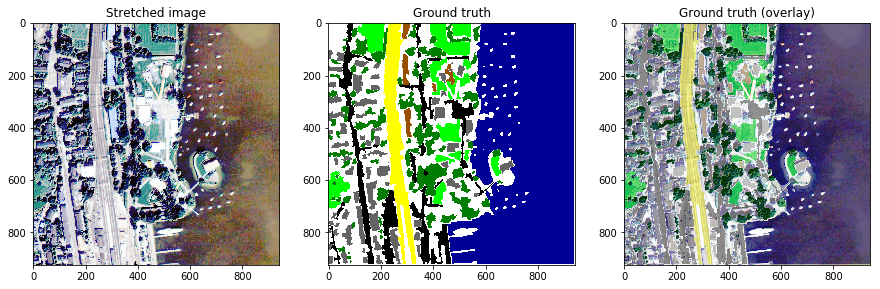

In [5]:
# Show image, its groundtruth image and overlay (to verify matching)
i = 2
alpha=.6
overlay = imgs_eq[i][:, :, :3] * alpha + gt[i] / 255 * (1-alpha)

# TODO don't stretch image

fig, axes = plt.subplots(1,3)
fig.set_size_inches(15,7)
axes[0].imshow(imgs[i][:,:,:3], cmap='Greys_r')
axes[1].imshow(gt[i]/255, cmap='Greys_r')
axes[2].imshow(overlay, cmap='Greys_r')
axes[0].set_title("Stretched image")
axes[1].set_title("Ground truth")
axes[2].set_title("Ground truth (overlay)")
plt.show()

## GT to labels
Next, we need to convert the ground truth (colors) to labels 

In [6]:
# get label corresponding to each color
legend = OrderedDict((('Background',[255, 255, 255]),
          ('Roads',[0, 0, 0]),
          ('Buildings',[100, 100, 100]),
          ('Trees',[0, 125, 0]),
          ('Grass',[0, 255, 0]),
          ('Bare Soil',[150, 80, 0]),
          ('Water',[0, 0, 150]),
          ('Railways',[255, 255, 0]),
          ('Swimming Pools',[150, 150, 255])))

# get class names by increasing value (as done above)
names, colors = [], []
for name, color in legend.items():
    names.append(name)
    colors.append(color)

In [7]:
gt_maj_label = gt_color_to_label(gt, colors)
flatten = lambda l: [item for sublist in l for item in sublist]
flat_labels = flatten(flatten(gt_maj_label))
print("Unique Labels in GT: ", np.unique(flat_labels))
print(np.shape(gt_maj_label))
gt = gt_maj_label

100%|██████████| 9/9 [00:05<00:00,  1.52it/s]


Unique Labels in GT:  [0. 1. 2. 3. 4. 5. 6. 7. 8.]
(20,)


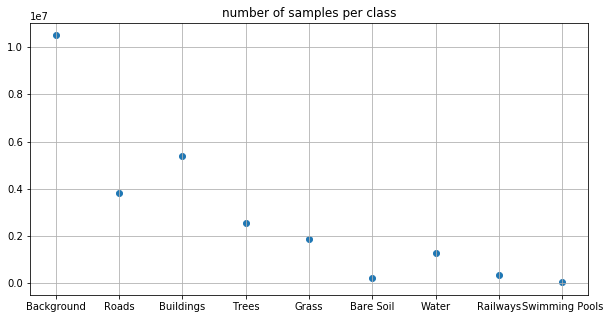

In [8]:
# print some statistics for the class distribution
unique, counts = np.unique(flat_labels,return_counts=True)
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 5)
ax.scatter(unique,counts)
ax.set_title('number of samples per class')
ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names)
ax.grid()
plt.show()

## Get patches

In [9]:
patch_size = 64
stride_train = 64 # has to be <= patch_size
stride_test = 32 # has to be <= patch_size


# ids for training, validation and test sets (0-19)
ids_train = np.arange(0,12)
ids_val = np.arange(12,16)
ids_test = np.arange(16,20)

# get training, test and validation sets
x_train = get_padded_patches(imgs[ids_train], patch_size = patch_size, stride = stride_train)
x_val = get_padded_patches(imgs[ids_val], patch_size = patch_size, stride = stride_train)
x_test = get_padded_patches(imgs[ids_test], patch_size = patch_size, stride = stride_test)
x_test_nostride = get_padded_patches(imgs[ids_test], patch_size = patch_size, stride = patch_size)

100%|██████████| 4/4 [00:00<00:00, 20.48it/s]


In [10]:
y_train_labels = get_gt_patches(gt[ids_train], patch_size = patch_size, stride = stride_train, central_label=True)
y_val_labels = get_gt_patches(gt[ids_val], patch_size = patch_size, stride = stride_train, central_label=True)
y_test_labels = get_gt_patches(gt[ids_test], patch_size = patch_size, stride = stride_test, central_label=True)
y_test_nostride_labels = get_gt_patches(gt[ids_test], patch_size = patch_size, stride = patch_size, central_label=True)

y_train = get_gt_patches(gt[ids_train], patch_size = patch_size, stride = stride_train)
y_val = get_gt_patches(gt[ids_val], patch_size = patch_size, stride = stride_train)
y_test = get_gt_patches(gt[ids_test], patch_size = patch_size, stride = stride_test)
y_test_nostride = get_gt_patches(gt[ids_test], patch_size = patch_size, stride = patch_size)

print(x_train.shape)
print(y_train.shape)

100%|██████████| 4/4 [00:00<00:00, 119.84it/s]

(3897, 64, 64, 4)
(3897, 64, 64)


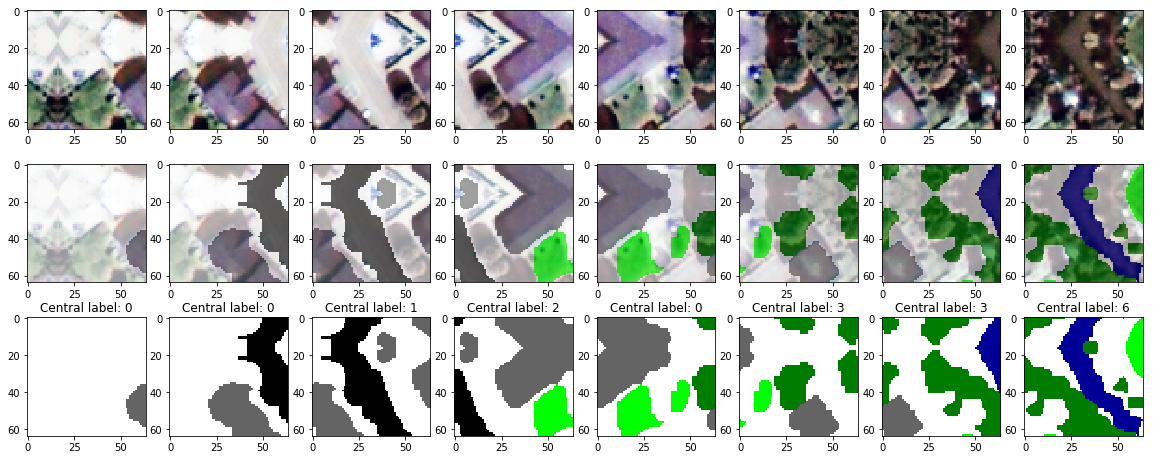

In [11]:
# visualize some patches 
imgs_row = 8
fig, axes = plt.subplots(3,imgs_row)
fig.set_size_inches(20,8)
offset = 0
alpha=.6
for i in range(offset, offset + imgs_row):
    axes[0][i-offset].imshow(x_test[i][:,:,:3])  # images
    axes[1][i-offset].imshow(gt_label_to_color(y_test[i], colors)*alpha+x_test[i][:,:,:3]*(1-alpha))  # ground truth (overlay)
    axes[2][i-offset].imshow(gt_label_to_color(y_test[i], colors))  # ground truth    
    axes[2][i-offset].set_title("Central label: "+str(y_test_labels[i]))

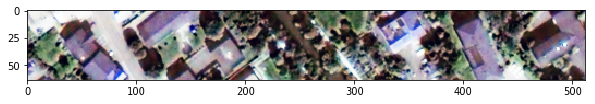

In [12]:
# corresponding part of image
plt.figure(figsize=(10,5))
plt.imshow(imgs[16][:64,:64*8,:3])

# Keras Semantic Segmentation CNN

Data Split: 
- Training: 12 images
- Validation: 4 images
- Test: 4 images

Tested Architectures: 

| Model | Patch Size | Data Augmentations | Number of Parameters | Testing Precision (avg) | Testing Recall (avg) | Testing f1 score (avg) | Validation / Test accuracy |
| ------- | ------- | ------- | ------- | ------- | ------- |
| U-Net | 64 | Rot 90°, Flipping  | 7,828,200 | 0.87 | 0.858 | 0.86 | t |
| U-Net | 128 | Rot 90°, Flipping  | 7,828,200 | 0.69 | 0.61 | 0.64 | t |
| U-Net | 128 | Rot 90°, Flipping  | 7,828,200 | 0.90 | 0.89 | 0.89 | v |

To Do
- Implement pixelwise class-weighted loss function
- Test same architectures on Pytorch

In [13]:
from __future__ import print_function
from sklearn.utils import class_weight
from keras.utils import to_categorical
from keras.models import load_model

In [14]:
# create copies of original data
x_train_patches = x_train.copy()
x_val_patches = x_val.copy()
x_test_patches = x_test.copy()

y_train_label = y_train.copy()
y_val_label = y_val.copy()
y_test_label = y_test.copy()

In [15]:
# get class weights
labels_unique = np.unique(y_train.flatten())
print(labels_unique)
class_weights = class_weight.compute_class_weight('balanced', labels_unique, y_train.flatten())    
class_weights[0] = 0 # give less weight to background label class
class_weights[5] = 7 # give less weight to bare soil class
class_weights[8] = 7 # give less weight to swimming pool class
#class_weights = np.concatenate([class_weights, [1]])
#class_weights.append(1) # give less weight to swimming pool class

print("Class weights:")
for i, w in enumerate(class_weights):
    print("%15s: %3.3f"%(names[i],w))

[0 1 2 3 4 5 6 7 8]
Class weights:
     Background: 0.000
          Roads: 0.757
      Buildings: 0.480
          Trees: 1.508
          Grass: 2.105
      Bare Soil: 7.000
          Water: 2.006
       Railways: 6.211
 Swimming Pools: 7.000


In [16]:
n_classes = 9

# convert to numpy arrays
x_train = np.asarray(x_train_patches)
x_val = np.asarray(x_val_patches)
x_test = np.asarray(x_test_patches)

# make y data categorical
y_train = to_categorical(y_train_labels, n_classes)
y_val = to_categorical(y_val_labels, n_classes)

In [17]:
# remove class
class_to_remove = 6
classes_to_keep = np.asarray([x for x in range(1,n_classes) if x!= class_to_remove])
print(classes_to_keep)

[1 2 3 4 5 7 8]


In [18]:
y_train = y_train[:,classes_to_keep]
y_val = y_val[:,classes_to_keep]
n_classes = len(classes_to_keep)
class_weights = class_weights[classes_to_keep]

In [19]:
# print shapes of variables
for var in x_train, y_train, x_val, y_val:
    print(np.shape(var))

(3897, 64, 64, 4)
(3897, 7)
(1117, 64, 64, 4)
(1117, 7)


# Keras Patch CNN

In [20]:
from keras.models import Sequential

In [21]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=x_train.shape[1:]))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        1184      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               7372928   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [22]:
def get_unet_down(n_classes, input_shape):
    """get UNET model instance"""

    inputs = Input(input_shape)

    conv1 = Conv2D(32, (5, 5), activation='relu', padding='same')(inputs)
    conv1 = Dropout(.1)(conv1)
    conv1 = Conv2D(32, (5, 5), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Dropout(.1)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Dropout(.1)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Dropout(.1)(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    lyr = Dropout(0.25)(pool4)
    lyr = Flatten()(lyr)
    lyr = Dense(128, activation='relu')(lyr)
    lyr = Dropout(0.5)(lyr)
    lyr = Dense(n_classes, activation='softmax')(lyr)

    model = Model(inputs=[inputs], outputs=[lyr])

    sgd = optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['acc', ignore_background_class_accuracy(0)])

    return model

## Train CNN

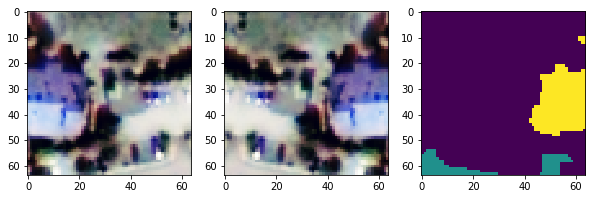

In [23]:
img_idx = 14
im_patches_vis, gt_patches_vis = augment_images_and_gt(x_train_patches[img_idx], y_train_label[img_idx], rf_h=True, rf_v=True, rot=True)

fig, axes = plt.subplots(1,3)
fig.set_size_inches((10,5))
axes[0].imshow(x_train_patches[img_idx][:,:,:3])
axes[1].imshow(im_patches_vis[:,:,:3])
axes[2].imshow(gt_patches_vis)
plt.show()

In [24]:
# callbacks (evaluated every epoch)
# show loss and accuracy figures after each epoch
callback_plot = PlotLosses()

# stop early if after several epochs the accuracy doesn't improive
callback_earlystop = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=24, verbose=1, mode='auto')

# decrease learning rate when accuracy stops improving
callback_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=12, verbose=1, mode='auto',
                                epsilon=1e-4, cooldown=0, min_lr=1e-8)

# checkpoint to save weights at every epoch (in case of interruption)
filepath = "weights-improvement.hdf5"
callback_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')

callback_tensorboard = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

Instructions for updating:
Use the retry module or similar alternatives.


<Figure size 432x288 with 0 Axes>

In [25]:
# train or load model
batch_size = 20
epochs = 10

def model_train(model, data_augmentation = True):
    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(batch_generator(x_train, y_train, 
                                        batch_size=batch_size, data_augmentation=data_augmentation),
                        steps_per_epoch=int(np.ceil(x_train.shape[0] / float(batch_size))),
                        epochs=epochs,
                        verbose=1,
                        class_weight = class_weights, # weights for loss function
                        validation_data=(x_val, y_val),
                        callbacks=[callback_earlystop,
                                   callback_lr,
                                   #callback_checkpoint,
                                   callback_plot,
                                   callback_tensorboard],
                        workers=multiprocessing.cpu_count(),
                        use_multiprocessing=True)

# train the model
#model = get_unet_down(n_classes, x_train.shape[1:])
#model_train(model, data_augmentation=False)
model = load_model('models_out/model_labels.h5', custom_objects={'fn': ignore_background_class_accuracy(0)})

In [26]:
# save the model
model.save('models_out/model_labels.h5')  # save model, weights

# Prediction

In [27]:
#y_pred = model.predict(x_test, batch_size = 20, verbose = 1)
y_pred = model.predict(x_train, batch_size = 20, verbose = 1)

3897/3897 [==============================] - 40s 10ms/step


In [45]:
y_pred_labels = get_y_pred_labels(y_pred, class_to_remove=class_to_remove)
#y_pred_label = y_pred

In [46]:
# Get accuracy as margin between highest and second highest class
y_pred_acc = get_accuracy_probas(y_pred)

In [51]:
# get pictures of prediction
y_pred_label = np.asarray([np.ones(np.shape(patch[...,0]))*y_pred_labels[idx] for idx, patch in enumerate(x_train)])
np.shape(y_pred_im)

(3897, 64, 64)

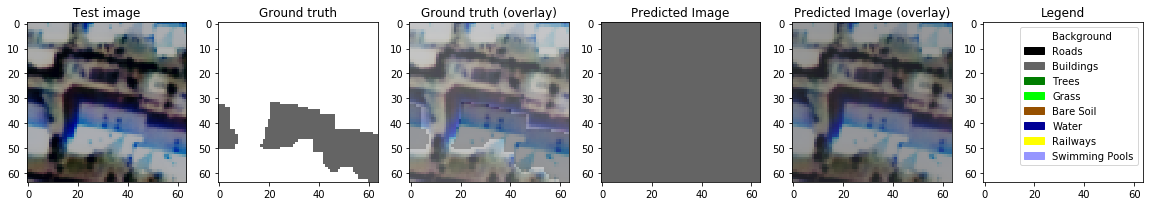

In [52]:
# plot prediction results
im_idx = 20
alpha = .3 # for overlay
fig, axes = plt.subplots(1,6)
fig.set_size_inches(20,20)
fig_im = x_train[im_idx][:,:,:3]*(1-alpha)
fig_test = gt_label_to_color(y_train_label[im_idx], colors)
fig_pred = gt_label_to_color(y_pred_label[im_idx], colors)

# plots
axes[0].imshow(fig_im)
axes[1].imshow(fig_test)
axes[2].imshow(fig_test*alpha+fig_im*(1-alpha))
axes[3].imshow(fig_pred)
axes[4].imshow(fig_pred*alpha+fig_im*(1-alpha))
axes[5].imshow(fig_im*0+1)

# titles
axes[0].set_title("Test image")
axes[1].set_title("Ground truth")
axes[2].set_title("Ground truth (overlay)")
axes[3].set_title("Predicted Image")
axes[4].set_title("Predicted Image (overlay)")
axes[5].set_title("Legend")

# legend
legend_data = [[l[0],l[1]] for l in legend.items()]
handles = [Rectangle((0,0),1,1, color = [v/255 for v in c]) for n,c in legend_data]
labels = np.asarray([n for n,c in legend_data])
axes[5].legend(handles,labels)


In [54]:
y_pred_im = [convert_patches_to_image(imgs, gt_label_to_color(y_pred_label, colors), img_idx=i, img_start=0, patch_size=64, stride=64) for i in range(0,3)]
y_test_im = [convert_patches_to_image(imgs, gt_label_to_color(y_train_label, colors), img_idx=i, img_start=0, patch_size=64, stride=64) for i in range(0,3)]

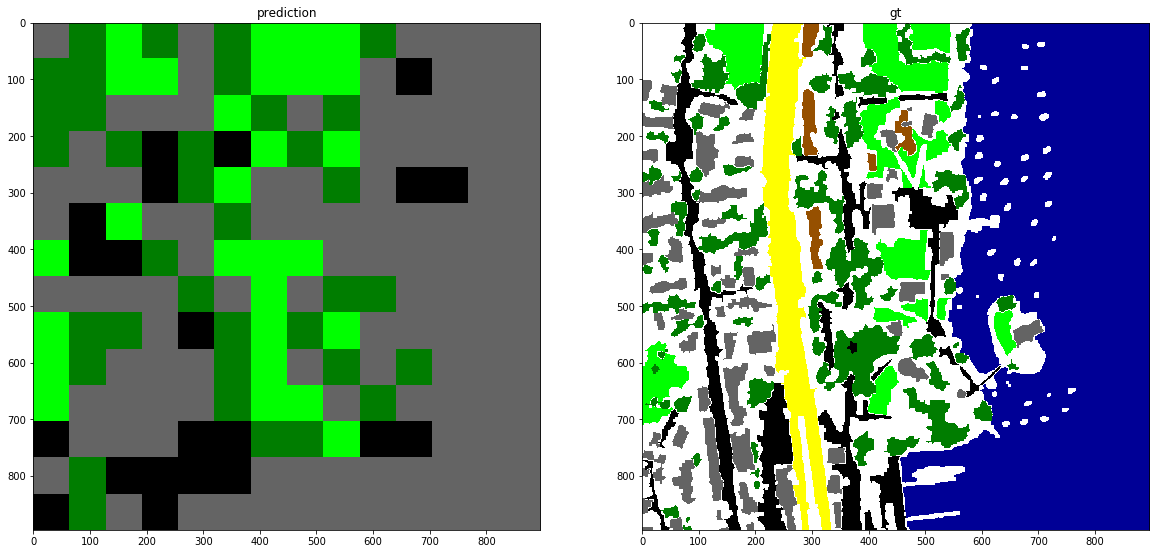

In [55]:
fig, axes = plt.subplots(1,2)
fig.set_size_inches((20,15))
img_idx = 2
axes[0].imshow(y_pred_im[img_idx]) # prediction 
axes[1].imshow(y_test_im[img_idx]) # gt stitched together 
[axes[i].set_title(["prediction", "gt", "image"][i]) for i in range(2)]
plt.show()

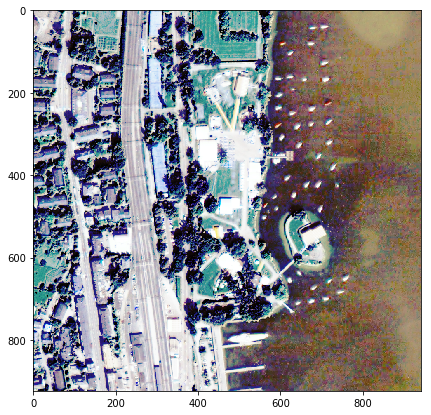

In [56]:
# show also original image
plt.figure(figsize=(7,7))
plt.imshow(imgs[img_idx][:, :, :3])
plt.show()

# Accuracy metrics

In [57]:
y_pred_labels_im = gt_color_to_label(np.multiply(deepcopy(y_pred_im),255), colors)
y_test_labels_im = gt_color_to_label(np.multiply(deepcopy(y_test_im),255), colors)

100%|██████████| 9/9 [00:00<00:00, 14.85it/s]


In [58]:
y_pred_flattened = [subitem for sublist in y_pred_labels_im.flatten() for item in sublist for subitem in item]
y_test_flattened = [subitem for sublist in y_test_labels_im.flatten() for item in sublist for subitem in item]

y_pred_flattened = np.asarray(y_pred_flattened).astype('int')
y_test_flattened = np.asarray(y_test_flattened).astype('int')

filter_items = (y_test_flattened !=0) & (y_test_flattened != class_to_remove)

In [59]:
# Validation accuracy
# mask background class for evaluation

#TODO ditinguish overall / average accuracy

print("Testing accuracy: %.3f" % metrics.accuracy_score(y_pred_flattened[filter_items],y_test_flattened[filter_items]))
print(metrics.classification_report(
    y_pred_flattened[filter_items],
    y_test_flattened[filter_items],
    target_names=np.asarray(labels)[classes_to_keep],
    digits=3))

Testing accuracy: 0.493
                precision    recall  f1-score   support

         Roads      0.274     0.343     0.304    209780
     Buildings      0.637     0.490     0.554    583917
         Trees      0.332     0.299     0.315    244775
         Grass      0.766     0.696     0.729    396179
     Bare Soil      0.000     0.000     0.000         0
      Railways      0.000     0.000     0.000         0
Swimming Pools      0.000     0.000     0.000         0

   avg / total      0.568     0.493     0.525   1434651



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# Certainty using Density Forest

In [ ]:
def get_activations(model, layer, im_batch):
    """
    Get activations from a layer in a Keras model
    :param model: trained Keras model
    :param layer: index of layer in Keras model
    :param im_batch: image batch
    :return: activations for every batch
    """
    get_activations_keras = k.function([model.layers[0].input, k.learning_phase()], [model.layers[layer].output, ])
    activations = get_activations_keras([im_batch, 0])
    return np.asarray(activations[0])


In [114]:
# image, layer indexes
layer_idx = -2
img_idx = 2
patches_begin = get_offset(imgs, 64, 64, 0, img_idx)
patches_end = get_offset(imgs, 64, 64, 0, img_idx+1)

# get activations
act_val = get_activations(model, layer_idx, x_val)
act_test = get_activations(model, layer_idx, x_train[patches_begin:patches_end])

In [115]:
# number of patches:
patches_end-patches_begin

196

In [116]:
act_test_1D = act_test
act_val_1D = act_val

In [117]:
# image indexes of images containing class to remove
idx_imgs = np.where(np.any(np.any(np.equal(y_val_label, class_to_remove),axis=1),axis=1))[0]

In [118]:
# get acctivations for unseen class
act_val_unseen = act_val[y_val_labels != class_to_remove]

In [119]:
# retain only activation weights for which there is a ground truth
filter_val = (y_val_labels != 0) & (y_val_labels != class_to_remove)
act_val = act_val[filter_val]

In [120]:
import sys
base_dir = '/Users/cyrilwendl/Documents/EPFL'  # for local machine
#base_dir = '/home/cyrilwendl'  # for GCE

sys.path.append(base_dir + '/SIE-Master/Code') # Path to density Tree package
sys.path.append(base_dir + '/SIE-Master/Code/density_tree') # Path to density Tree package

from density_tree.density_forest import *
from sklearn import decomposition

Variance explained by first 11 components: 0.95


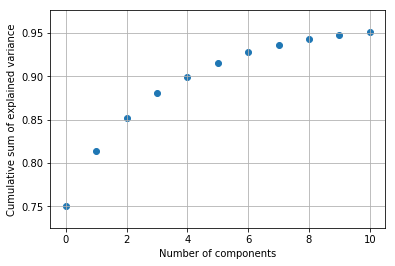

In [121]:
# create density tree for activation weights of training data
dimensions = np.shape(act_val)[-1]

# PCA
pca = decomposition.PCA(n_components=10)
pca.fit(act_val)
n_components = len(pca.explained_variance_ratio_[np.cumsum(pca.explained_variance_ratio_)<.95])+1
print("Variance explained by first %i components: %.2f" % (n_components, np.sum(pca.explained_variance_ratio_[:n_components])))
pca = decomposition.PCA(n_components=n_components)
pca.fit(act_val)

plt.cla()
plt.scatter(np.arange(n_components), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative sum of explained variance")
plt.grid()
plt.show()

In [122]:
X_val = pca.transform(act_val)
X_test = pca.transform(act_test_1D)
X_unseen = pca.transform(act_val_unseen)

# validation label
y_val_1D = y_val_labels[filter_val]

In [123]:
names_keep = np.asarray(names)[classes_to_keep]
names_keep = names_keep.tolist()

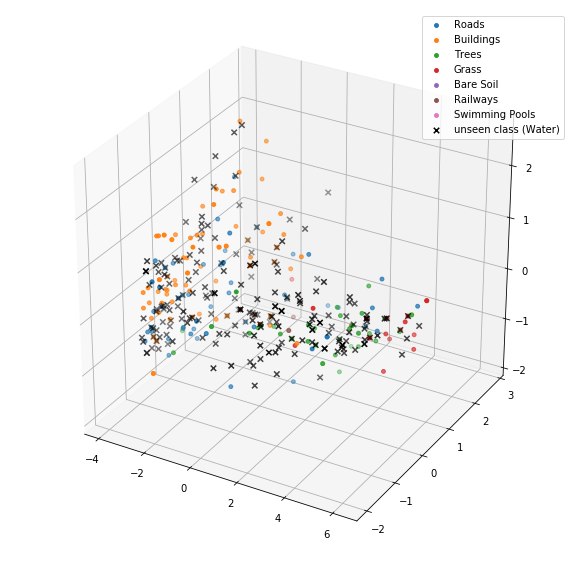

Variance explained by first 3 components: 0.85


In [124]:
# get data subset to show in figure
n_points = 200
dataset_indices = np.arange(len(X_val))

#  draw random samples with replacement
dataset_subset_indices = np.random.choice(dataset_indices, size=n_points, replace=True,)
dataset_subset = X_val[dataset_subset_indices, :]

dataset_indices = np.arange(len(X_unseen))
dataset_subset_indices_unseen = np.random.choice(dataset_indices, size=n_points, replace=True,)

# for interactive Jupyter Notebook
#%matplotlib inline
#%matplotlib notebook
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
for class_keep in classes_to_keep:
    plot_data = X_val[dataset_subset_indices][y_val_1D[dataset_subset_indices]==class_keep]
    plot_color = y_val_1D[dataset_subset_indices][y_val_1D[dataset_subset_indices]==class_keep]
    ax.scatter(plot_data[...,0], plot_data[...,1], zs=plot_data[...,2], cmap=plt.get_cmap('rainbow'), s=15)
    
ax.scatter(X_unseen[dataset_subset_indices_unseen,0], X_unseen[dataset_subset_indices_unseen,1], zs=X_unseen[dataset_subset_indices_unseen,2], c='black', s=30, marker='x', depthshade=True) 
names_legend = names_keep.copy()
names_legend.append('unseen class ('+names[class_to_remove]+')')
ax.legend(names_legend)
plt.savefig("../pca_components_3d_"+names[class_to_remove]+".pdf", bbox_inches='tight', pad_inches=0)
plt.show()

print("Variance explained by first 3 components: %.2f" % np.sum(pca.explained_variance_ratio_[:3]))

In [ ]:
warnings.filterwarnings("ignore")
subset_data = 0.01
print("Number of points on which to train trees: %i" % int(np.shape(X_val)[0] * subset_data))
root_nodes_seen = density_forest_create(X_val, n_classes, 10, subset_data, n_jobs=1, verbose=10)

In [ ]:
# get probabilities for one image
n_jobs = multiprocessing.cpu_count()
n_jobs = 1  # for MacOS
n_patches = np.shape(act_test)[0]
probas_seen = Parallel(n_jobs=n_jobs, verbose=1)(
        delayed(density_forest_traverse_x)(X_test[patch_idx*(patch_size * patch_size):(patch_idx+1)*(patch_size * patch_size),:], root_nodes_seen, thresh = 0)
        for patch_idx in range(im_idx+n_patches+1))

%clear

In [ ]:
probas = [y for patch in probas_seen for y in patch]

In [ ]:
probas_seen_im = np.reshape(probas.copy(), (n_patches, patch_size, patch_size))

# ad-hoc scaling of probabilities
# TODO replace by more rigorous standarization
#probas_seen_im = np.log(probas_seen_im)
#probas_seen_im = np.add(probas_seen_im, -np.nanmin(probas_seen_im[probas_seen_im!=-np.infty]))
#probas_seen_im = np.divide(probas_seen_im, np.nanmax(probas_seen_im[probas_seen_im!=np.infty]))

In [ ]:
# get predictions without for y without stride to show side-by-side
y_pred_nostride = model.predict(x_train, batch_size = 20, verbose = 1)
y_pred_nostride_label = get_y_pred_labels(y_pred_nostride, class_to_remove)

In [ ]:
# plot prediction results with new uncertainty
# %matplotlib inline
im_idx = 0
alpha = .3 # for overlay
fig, axes = plt.subplots(1,6)
fig.set_size_inches(20,20)
fig_im = x_train[im_idx][:,:,:3]*(1-alpha)
fig_test = gt_label_to_color(y_train_label[im_idx], colors)
fig_pred = gt_label_to_color(y_pred_nostride_label[im_idx], colors)

# plots
axes[0].imshow(fig_im)
axes[1].imshow(fig_test)
axes[2].imshow(fig_test*alpha+fig_im*(1-alpha))
axes[3].imshow(fig_pred)
axes[4].imshow(fig_pred*alpha+fig_im*(1-alpha))
axes[5].imshow(fig_im*0+1)

# titles
axes[0].set_title("Test image")
axes[1].set_title("Ground truth")
axes[2].set_title("Ground truth (overlay)")
axes[3].set_title("Predicted Image")
axes[4].set_title("Predicted Image (overlay)")
axes[5].set_title("Legend")

# legend
legend_data = [[l[0],l[1]] for l in legend.items()]
handles = [Rectangle((0,0),1,1, color = [v/255 for v in c]) for n,c in legend_data]
labels = [n for n,c in legend_data]
axes[5].legend(handles,labels)

# show certitude by network
im_overlay = get_fig_overlay(fig_im, probas_seen_im[im_idx], thresh=.93, opacity=.4)
fig, axes = plt.subplots(1,3)
fig.set_size_inches(14,6)
f1 = axes[0].imshow(y_pred_acc[im_idx], cmap='gray')
fig.colorbar(f1, ax=axes[0], orientation='horizontal')
f2 = axes[1].imshow(probas_seen_im[im_idx], cmap='gray')
fig.colorbar(f2, ax=axes[1], orientation='horizontal',spacing='proportional')
axes[0].set_title("Network Confidence")
axes[1].set_title("Density Forest")
axes[2].imshow(im_overlay)
plt.show()

In [ ]:
# convert patches to image
im_cert_out = convert_patches_to_image(imgs, probas_seen_im[:,:,:,np.newaxis], img_idx=img_idx, patch_size=64, stride=64, img_start=img_idx)

In [ ]:
# show certitude by network
im_cert_out_log = np.exp(np.exp(np.exp(im_cert_out[:,:,0])))
im_cert_out_log /= np.max(im_cert_out_log)
fig, axes = plt.subplots(1,2)
fig.set_size_inches(10,10)
axes[0].imshow(im_cert_out[:,:,0], cmap='gray')
axes[1].imshow(im_cert_out_log, cmap='gray')
axes[0].set_title("Network Confidence (log)")
axes[1].set_title("Network Confidence (exp(exp(exp(log))))")

# image, overlay
im_overlay = get_fig_overlay(imgs[img_idx][:im_cert_out.shape[0],:im_cert_out.shape[1],:3],im_cert_out_log,
                             thresh=.3,opacity=.3)

fig, axes = plt.subplots(1,3)
fig.set_size_inches(20,15)
axes[0].imshow(imgs[img_idx][:,:,:3], cmap='gray')
axes[1].imshow(gt_label_to_color(gt[img_idx],colors))
axes[2].imshow(im_overlay, cmap='gray')
titles=['image','gt','uncertain regions in red']
[axes[i].set_title(titles[i]) for i in range(len(titles))];

In [ ]:
av_cert = []
for label in np.arange(1,9):
    av_cert.append(np.mean(im_cert_out[gt[img_idx][:im_cert_out.shape[0],:im_cert_out.shape[1]]==label])) 
    
av_cert
print("Average certainty within class:")
for idx, w in enumerate(av_cert):
    print("%15s: %3.5f"%(names[idx+1],w)) 

In [ ]:
# ratio unseen class / seen classes
cert_unseen = av_cert[class_to_remove-1]
cert_seen = np.nanmean(np.asarray(av_cert)[av_cert!=cert_unseen])

print("Average certainty seen class:\t\t%.4f"%cert_unseen)
print("Average certainty unseen classes:\t%.4f"%cert_seen)
print("Ratio seen class / unseen classes:\t%.4f"%(cert_seen/cert_unseen))